<div align="center">
    <h1>DS-210: Programming for Data Science</h1>
    <h1>Lecture 31</h1>
</div>

# 1. Applications of priority queues: sorting and shortest paths
# 2. Slices


# <font color="red">1. Applications of priority queues: sorting and shortest paths</font>
# 2. Slices

# Last time: priority queues

Collection of items:
  * `push`: insert an item
  * `pop`: remove and return the greatest item in a collection
  

Popular implementation: **binary heap**
  * push and pop in $O(\log n)$ time
  * Rust: `std::collections::BinaryHeap<T>`

<div align="center">
    <img src="order.png" alt="[sample binary heap]" width="40%">
</div>

## Application 1: Sorting a.k.a. HeapSort

* Put everything into a priority queue
* Remove items in order

In [22]:
use std::collections::BinaryHeap;

fn heap_sort(v:&mut Vec<i32>) {
    let mut pq = BinaryHeap::new();
    for v in v.iter() {
        pq.push(*v);
    }
    for i in (0..v.len()).rev() {
        v[i] = pq.pop().unwrap();
    }
}

In [23]:
let mut v = vec![23,12,-11,-9,7,37,14,11];
heap_sort(&mut v);
v

[-11, -9, 7, 11, 12, 14, 23, 37]

**Total running time:** $O(n \log n)$ for $n$ numbers

## More direct, using Rust operations

In [8]:
fn heap_sort_2(v:Vec<i32>) -> Vec<i32> {
   BinaryHeap::from(v).into_sorted_vec()
}

No extra memory allocated: the initial vector, intermediate binary heap, and final vector all use the same space on the heap
* `BinaryHeap::from(v)` consumes `v`
* `into_sorted_vec()` consumes the intermediate binary heap

In [9]:
let mut v = vec![7,17,3,1,8,11];
heap_sort_2(v)

[1, 3, 7, 8, 11, 17]

Sorting already provided for vectors (currently use other algorithms): `sort` and `sort_unstable`

In [10]:
let mut v = vec![7,17,3,1,8,11];
v.sort();
v

[1, 3, 7, 8, 11, 17]

In [11]:
let mut v = vec![7,17,3,1,8,11];
v.sort_unstable();
v

[1, 3, 7, 8, 11, 17]

## Application 2: Shortest weighted paths (Dijkstra's algorithm)

* **Input graph:** edges with *positive* values, directed or undirected
* **Goal:** Compute all distances from a given vertex $v$

### Some quotes from Edjer Dijkstra

<em> The use of COBOL cripples the mind; its teaching should, therefore, be regarded as a criminal offence. </em>
 
<em> It is practically impossible to teach good programming to students that have had a prior exposure to BASIC: as potential programmers they are mentally mutilated beyond hope of regeneration. </em>

<em> One morning I was shopping in Amsterdam with my young fiancée, and tired, we sat down on the café terrace to drink a cup of coffee and I was just thinking... Eventually, that algorithm became to my great amazement, one of the cornerstones of my fame </em>

* Mark all nodes unvisited. Create a set of all the unvisited nodes called the unvisited set.
* Assign to every node a tentative distance value: set it to zero for our initial node and to infinity for all other nodes. During the run of the algorithm, the tentative distance of a node v is the length of the shortest path discovered so far between the node v and the starting node. Since initially no path is known to any other vertex than the source itself (which is a path of length zero), all other tentative distances are initially set to infinity. Set the initial node as current.
* For the current node, consider all of its unvisited neighbors and calculate their tentative distances through the current node. Compare the newly calculated tentative distance to the one currently assigned to the neighbor and assign it the smaller one. For example, if the current node A is marked with a distance of 6, and the edge connecting it with a neighbor B has length 2, then the distance to B through A will be 6 + 2 = 8. If B was previously marked with a distance greater than 8 then change it to 8. Otherwise, the current value will be kept.
* When we are done considering all of the unvisited neighbors of the current node, mark the current node as visited and remove it from the unvisited set. A visited node will never be checked again (this is valid and optimal in connection with the behavior in step 6.: that the next nodes to visit will always be in the order of 'smallest distance from initial node first' so any visits after would have a greater distance).
* If all nodes have been marked visited or if the smallest tentative distance among the nodes in the unvisited set is infinity (when planning a complete traversal; occurs when there is no connection between the initial node and remaining unvisited nodes), then stop. The algorithm has finished.
* Otherwise, select the unvisited node that is marked with the smallest tentative distance, set it as the new current node, and go back to step 3.


<div align="center">
    <b>[see the demo on the board]</b>
</div>

**How it works:**

* Greedily take the closest unprocessed vertex
  * Its distance must be correct
  
* Keep updating distances of unprocessed vertices


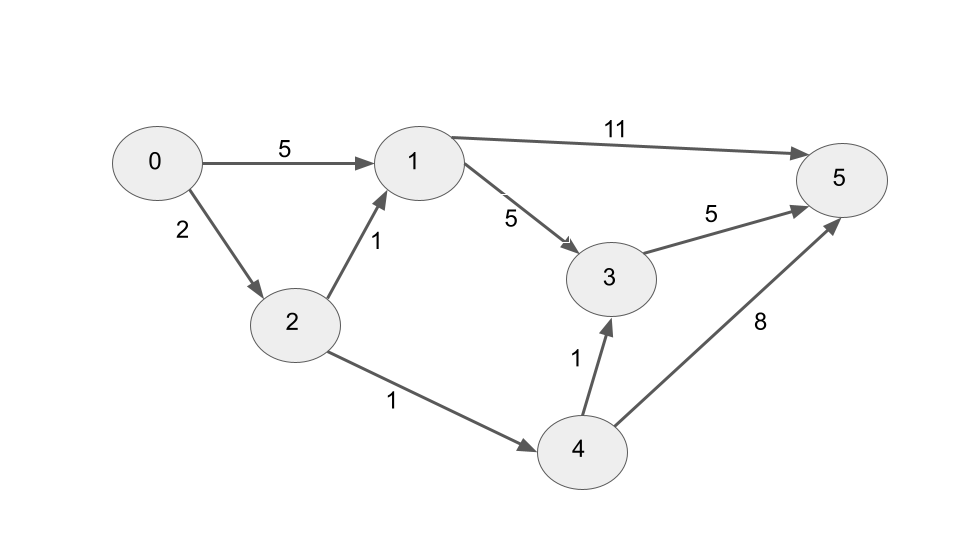

## Auxiliary graph definitions

In [12]:
use std::collections::BinaryHeap;

type Vertex = usize;
type Distance = usize;
type Edge = (Vertex, Vertex, Distance);

#[derive(Debug,Copy,Clone)]
struct Outedge {
    vertex: Vertex,
    length: Distance,
}

type AdjacencyList = Vec<Outedge>;

#[derive(Debug)]
struct Graph {
    n: usize,
    outedges: Vec<AdjacencyList>,
}

impl Graph {
    fn create_directed(n:usize,edges:&Vec<Edge>) -> Graph {
        let mut outedges = vec![vec![];n];
        for (u, v, length) in edges {
            outedges[*u].push(Outedge{vertex: *v, length: *length});
        }
        Graph{n,outedges}
    }
}

## Load our graph

In [13]:
let n = 6;
let edges: Vec<Edge> = vec![(0,1,5),(0,2,2),(2,1,1),(2,4,1),(1,3,5),(4,3,1),(1,5,11),(3,5,5),(4,5,8)];
let graph = Graph::create_directed(n, &edges);
graph

Graph { n: 6, outedges: [[Outedge { vertex: 1, length: 5 }, Outedge { vertex: 2, length: 2 }], [Outedge { vertex: 3, length: 5 }, Outedge { vertex: 5, length: 11 }], [Outedge { vertex: 1, length: 1 }, Outedge { vertex: 4, length: 1 }], [Outedge { vertex: 5, length: 5 }], [Outedge { vertex: 3, length: 1 }, Outedge { vertex: 5, length: 8 }], []] }

## Our implementation

In [18]:
let start: Vertex = 0;

let mut distances: Vec<Option<Distance> > = vec![None; graph.n];
distances[start] = Some(0);

In [19]:
use core::cmp::Reverse;

let mut pq = BinaryHeap::<Reverse<(Distance,Vertex)>>::new();
pq.push(Reverse((0,start)));

In [20]:
while let Some(Reverse((dist,v))) = pq.pop() {
    for Outedge{vertex,length} in graph.outedges[v].iter() {
        let new_dist = dist + *length;
        let update = match distances[*vertex] {
            None => {true} |
            Some(d) => {new_dist < d}
        };
        if update {
            distances[*vertex] = Some(new_dist);
            pq.push(Reverse((new_dist,*vertex)));
        }
    }
};

In [21]:
distances

[Some(0), Some(3), Some(2), Some(4), Some(3), Some(9)]

### Complexity and properties of Dijkstra's algorithm
* $O(V^2)$
* Works just as well with undirected graphs
* Doesn't work if path weights can be negative (why?)

## Traveling salesman

On the surface similar to shortest paths

Given an undirected graph with weighted non-negative edges find the shortest path that starts at a specified vertex, traverses every vertex in the graph and returns to the starting point

#### BUT

Much harder to solve (will not cover here).  Provably NP-complete (can not be solved in Polynomial time)

Held-Karp algorithm one of the best exact algorithms with complexity $O(n^2*2^n)$  
Many heuristics that run fast but yield suboptimal results

### Greedy Heuristic

Mark all nodes as unvisited. 
Use your starting node and pick the next node with shortest distance and visit it.  DFS using minimum distance criteria until all nodes have been visited.

### Minimum Spanning Tree Heuristic

https://apps.dtic.mil/dtic/tr/fulltext/u2/a025602.pdf  
Runs in $O(N)$ time and guaranteed to be no more than 50% worse than the optimal.

### More recently

https://arxiv.org/pdf/2007.01409.pdf (March 2022).   
0.2 billionth of a trillionth of a trillionth of a percent better but the first improvement since 1976.

## Slices

Slice = reference to subsection of the data

Slices of an array:
 * array of type `[T, _]`
 * slice of type `&[T]` or `&mut [T]`

In [14]:
{
    // immutable slice of an array
    let arr: [i32; 5] = [0,1,2,3,4];
    let slice: &[i32] = &arr[1..3];
    println!("{:?}",slice);
    println!("{}", slice[0]);
};

[1, 2]
1


In [15]:
{
    // mutable slice of an array
    let mut arr = [0,1,2,3,4];
    let mut slice = &mut arr[2..4];
    println!("{:?}",slice);
    slice[0] = slice[0] * slice[0];
    println!("{}", slice[0]);
    println!("{:?}",arr);
};

[2, 3]
4
[0, 1, 4, 3, 4]


## Slices

Work for vectors too!

In [16]:
let mut v = vec![0,1,2,3,4];
{
    let slice = &v[1..3];
    println!("{:?}",slice);
};

[1, 2]


In [17]:
{
    let mut slice = &mut v[1..3];
    
    // iterating over slices works as well
    for x in slice.iter_mut() {
        *x *= 1000;
    }
};
v

[0, 1000, 2000, 3, 4]

## Slices are references: all borrowing rules still apply!

* At most one mutable reference at a time
* No immutable references allowed with a mutable reference
* Many immutable references allowed simultaneously

In [18]:
// this won't work!
let mut v = vec![1,2,3,4,5,6,7];
{
    let ref_1 = &mut v[2..5];
    let ref_2 = &v[1..3];
    ref_1[0] = 7;
    println!("{}",ref_2[1]);
}

Error: cannot borrow `v` as immutable because it is also borrowed as mutable

In [19]:
// and this reordering will
let mut v = vec![1,2,3,4,5,6,7];
{
    let ref_1 = &mut v[2..5];
    ref_1[0] = 7;
    let ref_2 = &v[1..3];
    println!("{}",ref_2[1]);
};

7


## Memory representation of slices

* Pointer (to heap or stack)
* Length

**Compared to vector:** no capacity (cannot be extended)

<div align="center">
    <img src="rust_container_cheat_sheet_cropped.png" alt="[Cropped Rust container cheat sheet]" width="35%">
</div>

<div class="small">
<font size="2">Cropped from "Rust container cheat sheet" by Raph Levien, Copyright Google Inc. 2017
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
Source: <a href="https://docs.google.com/presentation/d/1q-c7UAyrUlM-eZyTo1pd8SZ0qwA_wYxmPZVOQkoDmH4/edit#slide=id.p">https://docs.google.com/presentation/d/1q-c7UAyrUlM-eZyTo1pd8SZ0qwA_wYxmPZVOQkoDmH4/edit#slide=id.p</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
    License: CC BY (<a href="https://creativecommons.org/licenses/by/4.0">https://creativecommons.org/licenses/by/4.0</a>)</font><br>
</div>